<a href="https://colab.research.google.com/github/2303a51851/PDS-Project/blob/main/Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

✅ TensorFlow version: 2.19.0
✅ Dataset Loaded Successfully!
Columns: ['Year', 'State Name', 'Dist Name', 'RICE YIELD (Kg per ha)', 'KHARIF SORGHUM YIELD (Kg per ha)', 'PEARL MILLET YIELD (Kg per ha)', 'MAIZE YIELD (Kg per ha)', 'FINGER MILLET YIELD (Kg per ha)', 'PIGEONPEA YIELD (Kg per ha)', 'MINOR PULSES YIELD (Kg per ha)', 'SESAMUM YIELD (Kg per ha)', 'SAFFLOWER YIELD (Kg per ha)', 'CASTOR YIELD (Kg per ha)', 'SUNFLOWER YIELD (Kg per ha)', 'SOYABEAN YIELD (Kg per ha)', 'OILSEEDS YIELD (Kg per ha)', 'SUGARCANE YIELD (Kg per ha)', 'COTTON YIELD (Kg per ha)', 'NITROGEN PER HA OF GCA (Kg per ha)', 'PHOSPHATE PER HA OF GCA (Kg per ha)', 'POTASH PER HA OF GCA (Kg per ha)', 'AVERAGE RAINFALL (Millimeters)', 'AVERAGE TEMPERATURE (Centigrate)', 'AVERAGE PERCIPITATION (Millimeters)', 'SOIL TYPE PERCENT1 (Percent)']
   Year    State Name Dist Name  RICE YIELD (Kg per ha)  \
0  1966  Chhattisgarh      Durg                  337.59   
1  1967  Chhattisgarh      Durg                  747.71   
2  

/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


🤖 Training Model: ANN (Feedforward Neural Network)
101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
✅ R² Score: 0.8673
✅ MAE: 233.5954
✅ RMSE: 347.9451


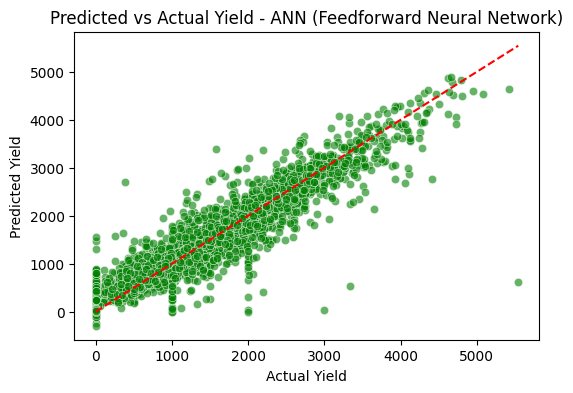

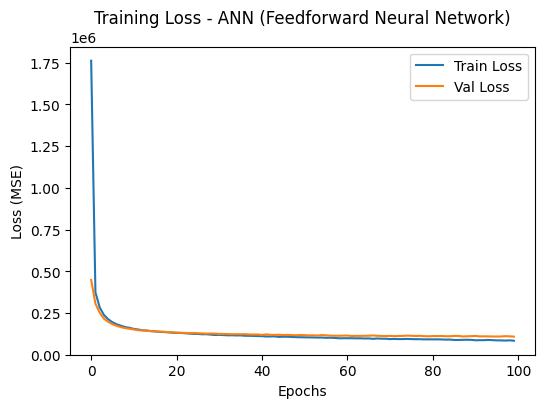

🤖 Training Model: CNN (1D Convolutional Network)


In [ ]:
# =====================================================================
# 🌾 Crop Yield Prediction using Rainfall, Pesticides, and Temperature
# Deep Learning Model Comparison
# =====================================================================

# ---------------------------------------------------------------------
# 📦 Import Libraries
# ---------------------------------------------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

print("✅ TensorFlow version:", tf.__version__)

# ---------------------------------------------------------------------
# 1️⃣ Load Dataset
# ---------------------------------------------------------------------
df = pd.read_csv("/content/Crop_Yield_Prediction .csv")  # change path if needed
print("✅ Dataset Loaded Successfully!")
print("Columns:", list(df.columns))
print(df.head())

# ---------------------------------------------------------------------
# 2️⃣ Feature and Target Selection (Auto-detect yield column)
# ---------------------------------------------------------------------
possible_yield_cols = [c for c in df.columns if "yield" in c.lower() or "production" in c.lower()]
if len(possible_yield_cols) == 0:
    raise KeyError("❌ No column found containing 'yield' or 'production'. Please check your CSV headers.")
else:
    target_col = possible_yield_cols[0]
    print(f"✅ Detected target column: '{target_col}'")

X = df.drop(columns=[target_col])
y = df[target_col]

# ---------------------------------------------------------------------
# 3️⃣ Train/Test Split
# ---------------------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print(f"Training samples: {X_train.shape[0]}, Testing samples: {X_test.shape[0]}")

# ---------------------------------------------------------------------
# 4️⃣ Preprocessing: Scale Numeric + Encode Categorical
# ---------------------------------------------------------------------
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(exclude=[np.number]).columns.tolist()

if len(categorical_features) == 0:
    preprocess = ColumnTransformer([("num", StandardScaler(), numeric_features)], remainder="drop")
else:
    preprocess = ColumnTransformer([
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ])

# Fit transform
X_train_proc = preprocess.fit_transform(X_train)
X_test_proc = preprocess.transform(X_test)

# Convert sparse → dense if needed
X_train_proc = X_train_proc.toarray() if not isinstance(X_train_proc, np.ndarray) else X_train_proc
X_test_proc = X_test_proc.toarray() if not isinstance(X_test_proc, np.ndarray) else X_test_proc

# Ensure float dtype
X_train_proc = X_train_proc.astype(np.float32)
X_test_proc = X_test_proc.astype(np.float32)
y_train = y_train.astype(np.float32)
y_test = y_test.astype(np.float32)

print("✅ Data Preprocessing Completed!")
print("Input Feature Dimension:", X_train_proc.shape[1])

# ---------------------------------------------------------------------
# 5️⃣ Define Deep Learning Models
# ---------------------------------------------------------------------
def build_ann(input_dim):
    model = models.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(64, activation='relu'),
        layers.Dense(1, activation='linear')
    ])
    model.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss='mse')
    return model

def build_cnn(input_dim):
    model = models.Sequential([
        layers.Reshape((input_dim, 1), input_shape=(input_dim,)),
        layers.Conv1D(64, 2, activation='relu'),
        layers.MaxPooling1D(),
        layers.Conv1D(128, 2, activation='relu'),
        layers.GlobalAveragePooling1D(),
        layers.Dense(64, activation='relu'),
        layers.Dense(1, activation='linear')
    ])
    model.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss='mse')
    return model

def build_lstm(input_dim):
    model = models.Sequential([
        layers.Reshape((input_dim, 1), input_shape=(input_dim,)),
        layers.LSTM(64, activation='tanh', return_sequences=False),
        layers.Dense(32, activation='relu'),
        layers.Dense(1, activation='linear')
    ])
    model.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss='mse')
    return model

models_dict = {
    "ANN (Feedforward Neural Network)": build_ann(X_train_proc.shape[1]),
    "CNN (1D Convolutional Network)": build_cnn(X_train_proc.shape[1]),
    "LSTM (Sequential Model)": build_lstm(X_train_proc.shape[1]),
}

# ---------------------------------------------------------------------
# 6️⃣ Train, Evaluate, and Compare Models
# ---------------------------------------------------------------------
EPOCHS = 100
BATCH_SIZE = 32
es = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=0)

results = []

for name, model in models_dict.items():
    print("=" * 80)
    print(f"🤖 Training Model: {name}")

    history = model.fit(
        X_train_proc, y_train,
        validation_split=0.15,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=[es],
        verbose=0
    )

    # Predictions
    preds = model.predict(X_test_proc).flatten()

    # Metrics
    r2 = r2_score(y_test, preds)
    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))

    print(f"✅ R² Score: {r2:.4f}")
    print(f"✅ MAE: {mae:.4f}")
    print(f"✅ RMSE: {rmse:.4f}")

    results.append({"Model": name, "R2": r2, "MAE": mae, "RMSE": rmse})

    # Plot: Predicted vs Actual
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=y_test, y=preds, color="green", alpha=0.6)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel("Actual Yield")
    plt.ylabel("Predicted Yield")
    plt.title(f"Predicted vs Actual Yield - {name}")
    plt.show()

    # Plot: Training Loss Curve
    plt.figure(figsize=(6, 4))
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Val Loss")
    plt.title(f"Training Loss - {name}")
    plt.xlabel("Epochs")
    plt.ylabel("Loss (MSE)")
    plt.legend()
    plt.show()

# ---------------------------------------------------------------------
# 7️⃣ Summary Table and Bar Graph
# ---------------------------------------------------------------------
results_df = pd.DataFrame(results).sort_values(by="R2", ascending=False)
print("\n📊 Deep Learning Model Performance Summary (sorted by R²):\n")
print(results_df.to_string(index=False))

# Barplot Comparison
plt.figure(figsize=(10, 5))
sns.barplot(x="Model", y="R2", data=results_df, palette="viridis")
plt.xticks(rotation=45, ha="right")
plt.title("Deep Learning Model Comparison - R² Score")
plt.show()
